In [3]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ggpubr))

library(parallel)
library(data.table)
library(cowplot)
library(ggsci)
library(aplot)
library(plyr)
options(warn=-1)


In [2]:
levels='L3'
file_list<-list.files(path = paste0("/home//jupyter/BRI_Analysis/scRNA/Analysis-Cross-Sectional/02B_DESeq2_BR1_VS_BR2_",levels), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [4]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [5]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >= 0.1 & padj <=  0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [6]:
selected_celltype<-unique(DEG$celltype)

In [7]:
DEG_sub<-DEG %>% filter(!Expression=="Unchanged")

In [8]:
table(DEG_sub$celltype)


           CD27- effector B cell            CD27+ effector B cell 
                               6                                5 
                        CD4 MAIT               CD56bright NK cell 
                               5                                1 
                        CD8 MAIT                            CD8aa 
                               9                              186 
                            cDC1                    CM CD4 T cell 
                               1                              142 
                   CM CD8 T cell               Core CD14 monocyte 
                             242                               22 
              Core CD16 monocyte               Core memory B cell 
                               3                               23 
               Core naive B cell            Core naive CD4 T cell 
                               1                              358 
          Core naive CD8 T cell                         DN T 

# Composition Scores

## Y1D0

In [14]:
meta_data<-read.csv('SF4_meta_data-2024-05-05.csv')

In [15]:
selected_type_list<-as.data.frame(table(DEG_sub$celltype)) %>% filter(Freq>50)

In [47]:
gsub('Core naive CD8 T cell','Core naive CD8 T cell ',selected_celltype)

[1] "Core naive CD8 T cell "

In [49]:
mean_df_summary_all<-data.frame()
for (selected_celltype in selected_type_list$Var1){
print(selected_celltype)
selected_gene=DEG_sub %>% filter(celltype ==selected_celltype) %>% select(X) %>% pull()

df_list<-mclapply(meta_data$pbmc_sample_id,function(X){
df<-read.csv(paste0('/home//jupyter/BRI_Analysis/scRNA/Analysis_SF4/Average_Expression_by_Celltype_and_Sample/',X,'_AIFI_L3.csv'),
             check.names = FALSE, row.names=1)
colnames(df)<-gsub('Core naive CD8 T cell','Core naive CD8 T cell ',colnames(df)) 
selected_celltype<-intersect(colnames(df),selected_celltype)
    
df_subset<-df[selected_gene,selected_celltype,drop = FALSE]
df_subset$pbmc_sample_id<-X
df_subset$Gene<-rownames(df_subset)

df_subset<-   pivot_longer(df_subset, 
                        cols = -c(pbmc_sample_id,Gene), 
                        names_to = "AIFI_L3",  
                        values_to = "Mean_Expression") 
return(df_subset)
},mc.cores=60)
    
    
mean_df<-do.call(rbind, df_list)
mean_df<-left_join(mean_df,meta_data)
mean_df<-as.data.frame(mean_df[!is.na(mean_df$X),])
mean_df$Mean_Expression<-as.numeric(mean_df$Mean_Expression)    
mean_df<-left_join(mean_df,DEG_sub,by= c("Gene" = "X","AIFI_L3" = "celltype"))
    
min_n <- DEG_sub %>%
  filter(celltype == selected_celltype) %>%
  dplyr::count(Expression) %>%
  summarise(min_count = min(n)) %>%
  pull(min_count)

top_n <- min(min_n, 100)
    
top_deg<-DEG_sub %>% filter(celltype ==selected_celltype) %>% 
    filter(Expression=="Down-regulated") %>% arrange(padj,desc(abs(log2FoldChange))) %>% slice_head(n=top_n)

mean_df_sub<-mean_df %>% filter(Gene %in% top_deg$X)
mean_df_sub<-mean_df_sub %>% group_by(Gene) %>% mutate(Z_score_Mean_Expression=scale(Mean_Expression))  %>% 
                                        mutate(composititon_score=Mean_Expression)  %>% 
                                        ungroup()
mean_df_summary<-mean_df_sub%>% group_by(pbmc_sample_id) %>% 
  dplyr::summarise(total_scores = sum(composititon_score))
mean_df_summary<-left_join(mean_df_summary,meta_data)
mean_df_summary$celltype<-selected_celltype

mean_df_summary_all<-rbind.fill(mean_df_summary_all,mean_df_summary)
}

[1] "CD8aa"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "CM CD4 T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "CM CD8 T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive CD4 T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive CD8 T cell "


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "DN T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB- CD27- EM CD4 T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB- CD27+ EM CD4 T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK+ CD27+ EM CD8 T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "ISG+ naive CD4 T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "Naive CD4 Treg"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "SOX4+ naive CD4 T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


In [50]:
mean_df_summary_all$ageAtEnrollment<-as.numeric(mean_df_summary_all$ageAtEnrollment)

`geom_smooth()` using formula = 'y ~ x'


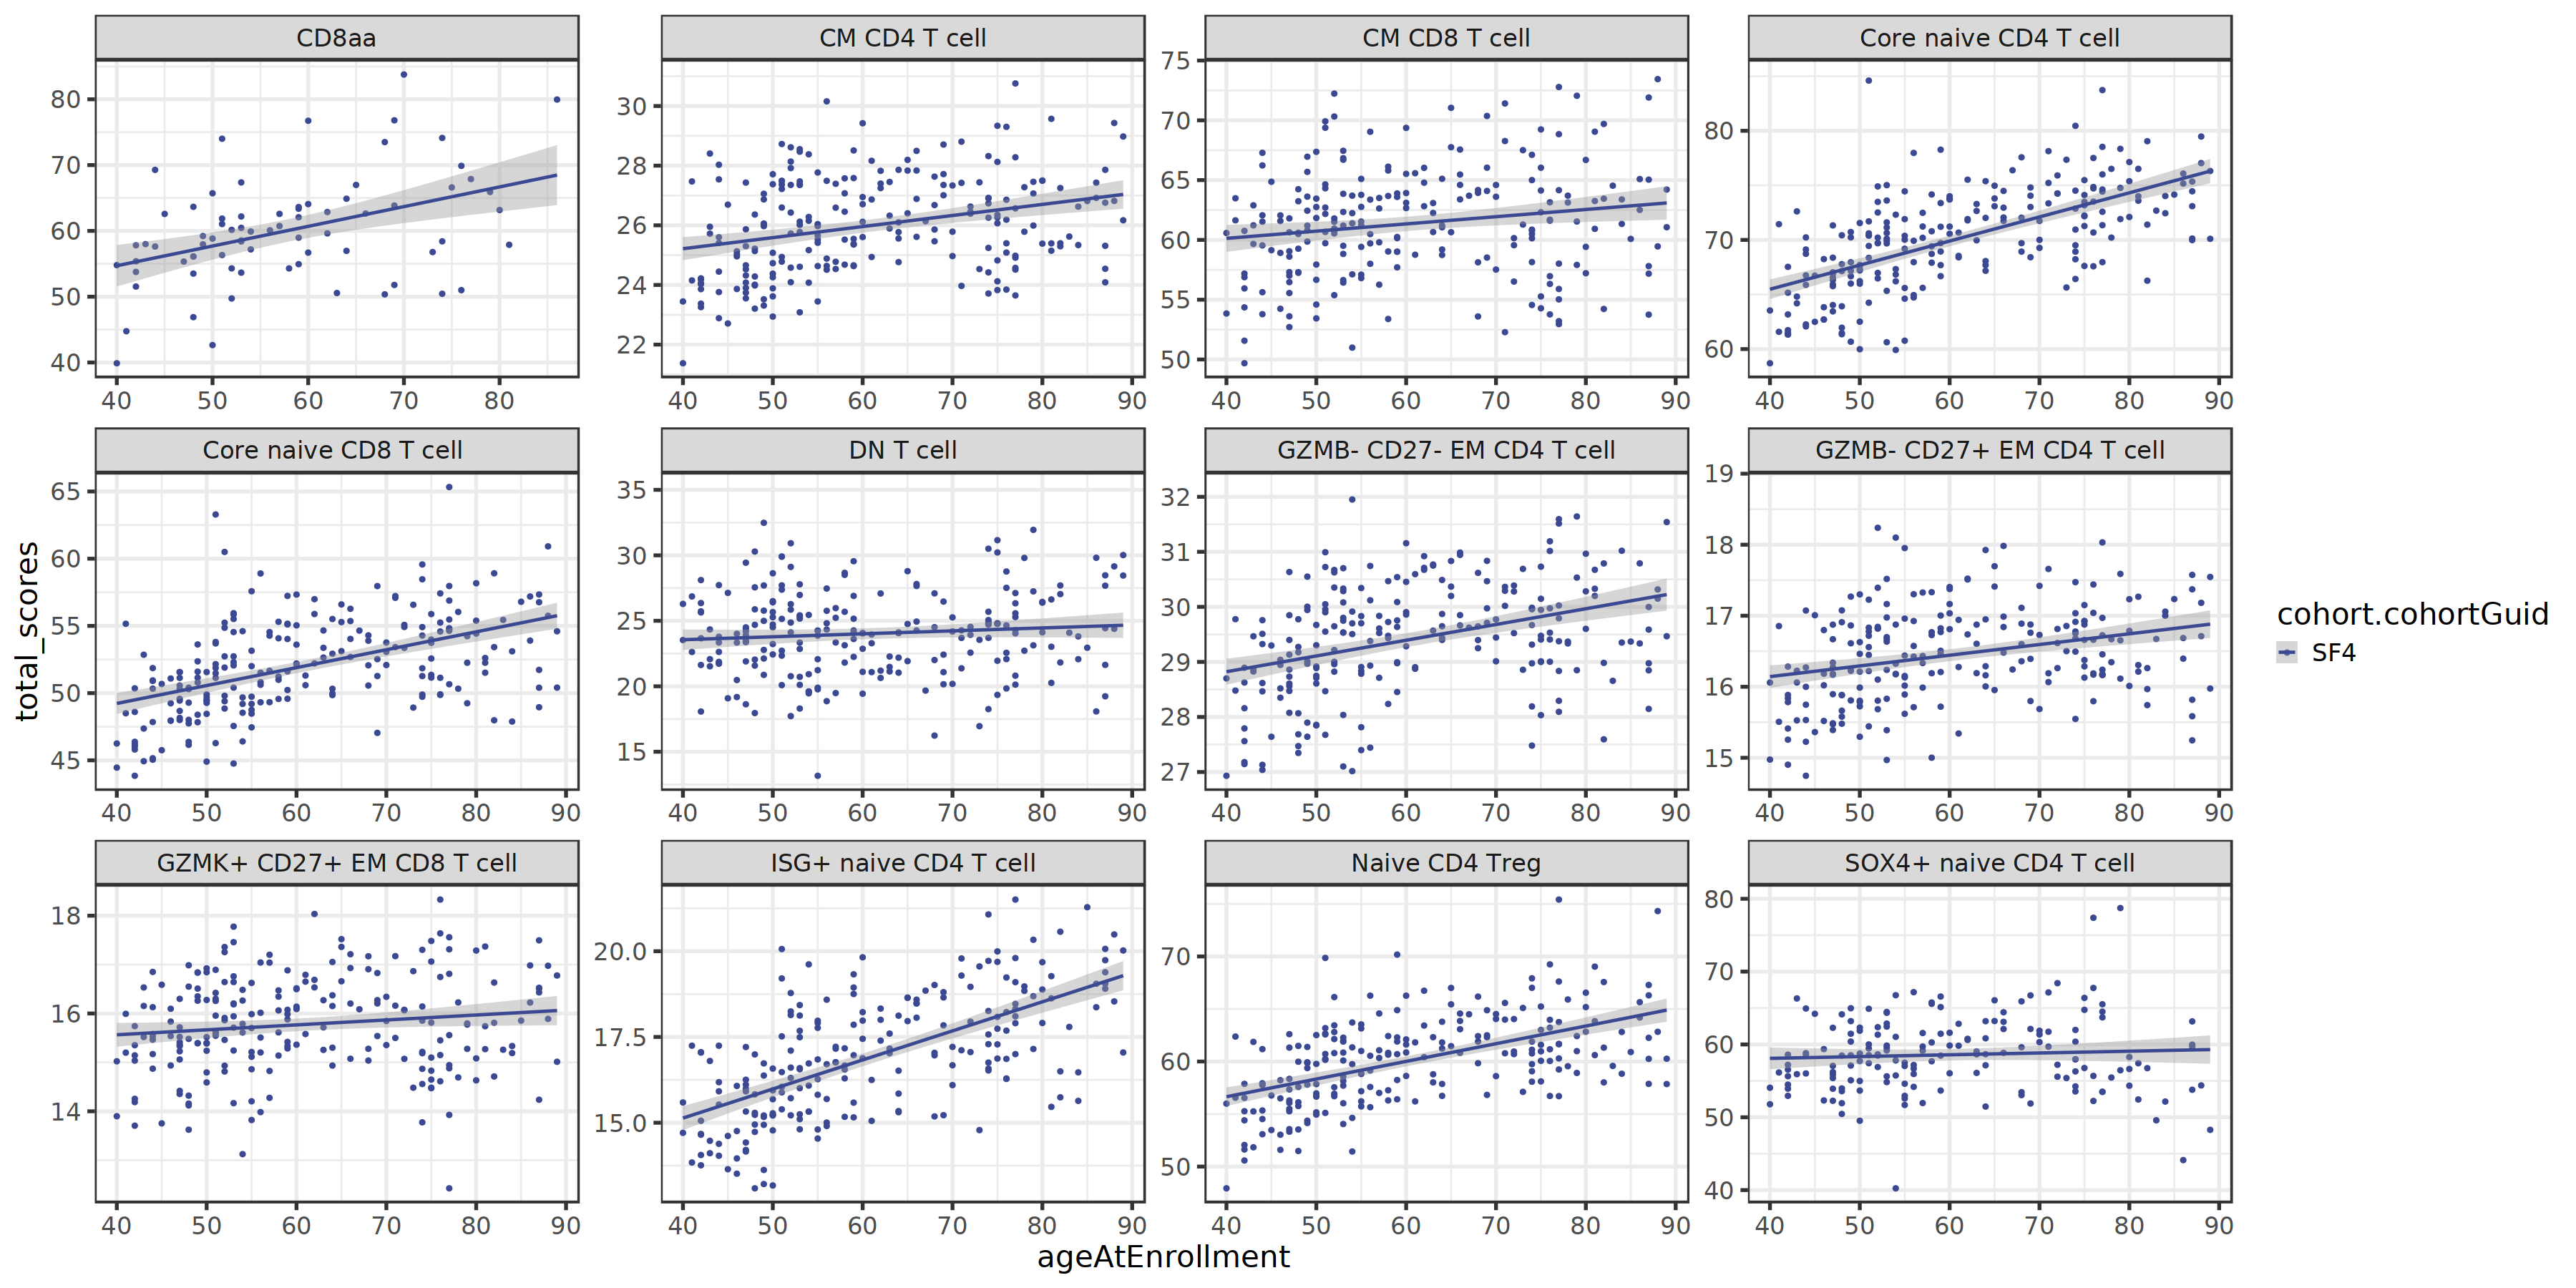

In [51]:
options(repr.plot.width = 30, repr.plot.height = 15)

ggplot(mean_df_summary_all,aes(ageAtEnrollment, total_scores,color =cohort.cohortGuid)) +
  geom_point()+
  geom_smooth(method='lm')+scale_color_aaas()+facet_wrap(~celltype,scale="free")+theme_bw(base_size=25)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


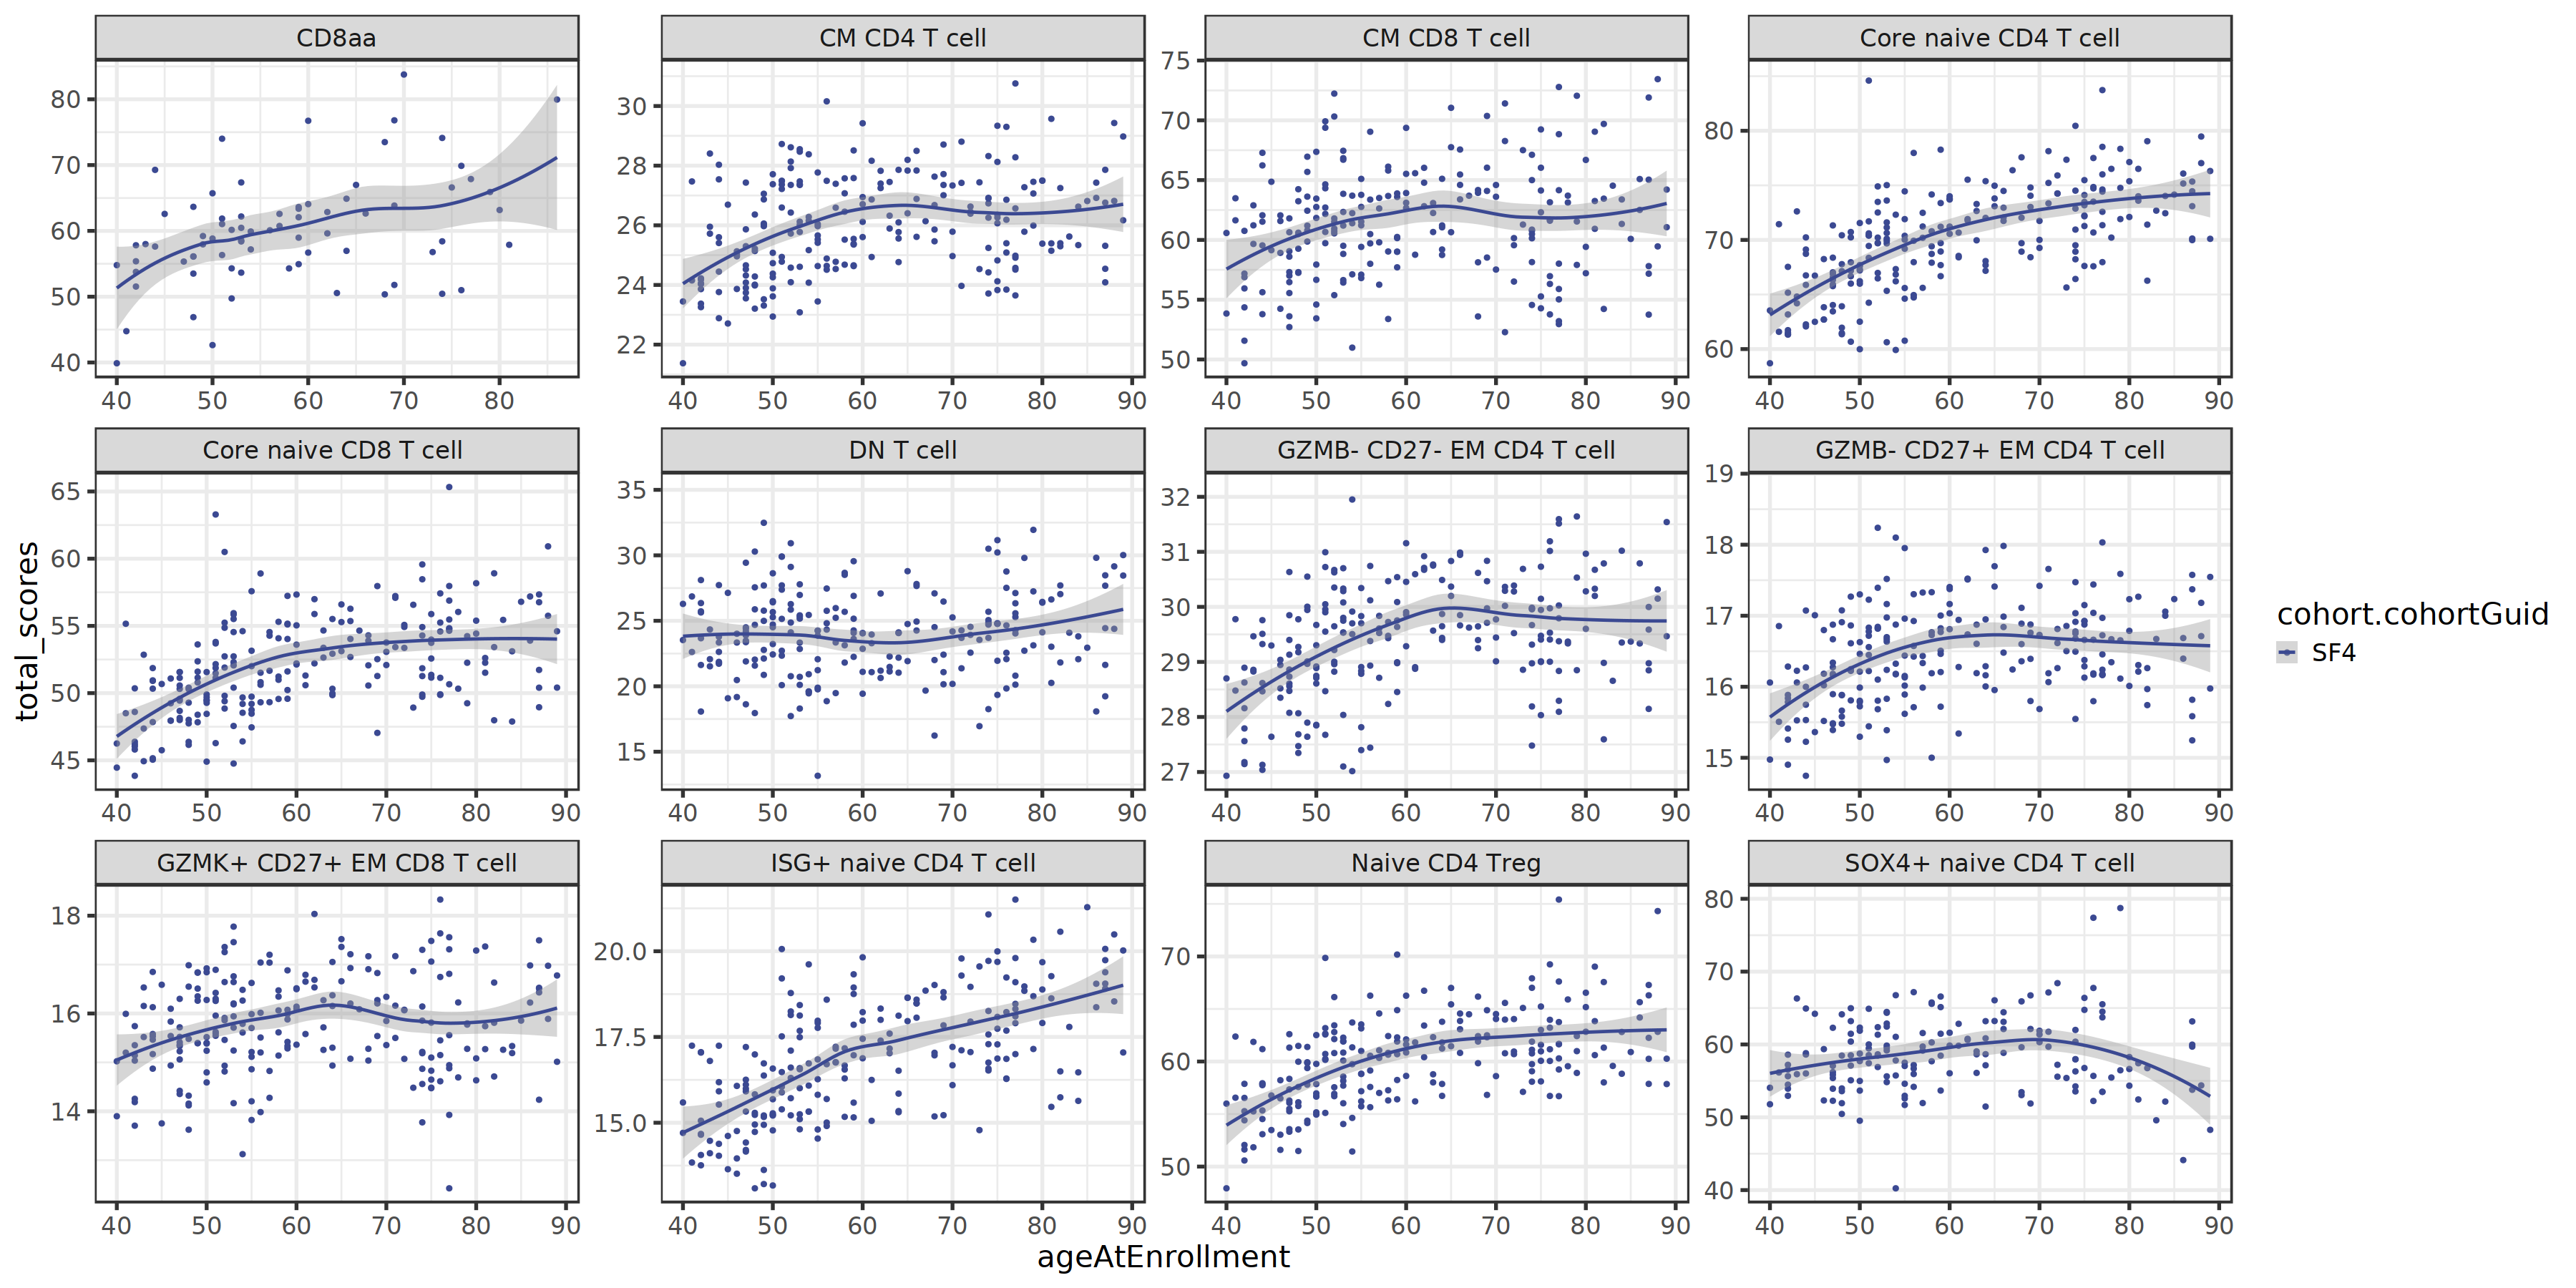

In [52]:
options(repr.plot.width = 30, repr.plot.height = 15)

ggplot(mean_df_summary_all,aes(ageAtEnrollment, total_scores,color =cohort.cohortGuid)) +
  geom_point()+
  geom_smooth()+scale_color_aaas()+facet_wrap(~celltype,scale="free")+theme_bw(base_size=25)

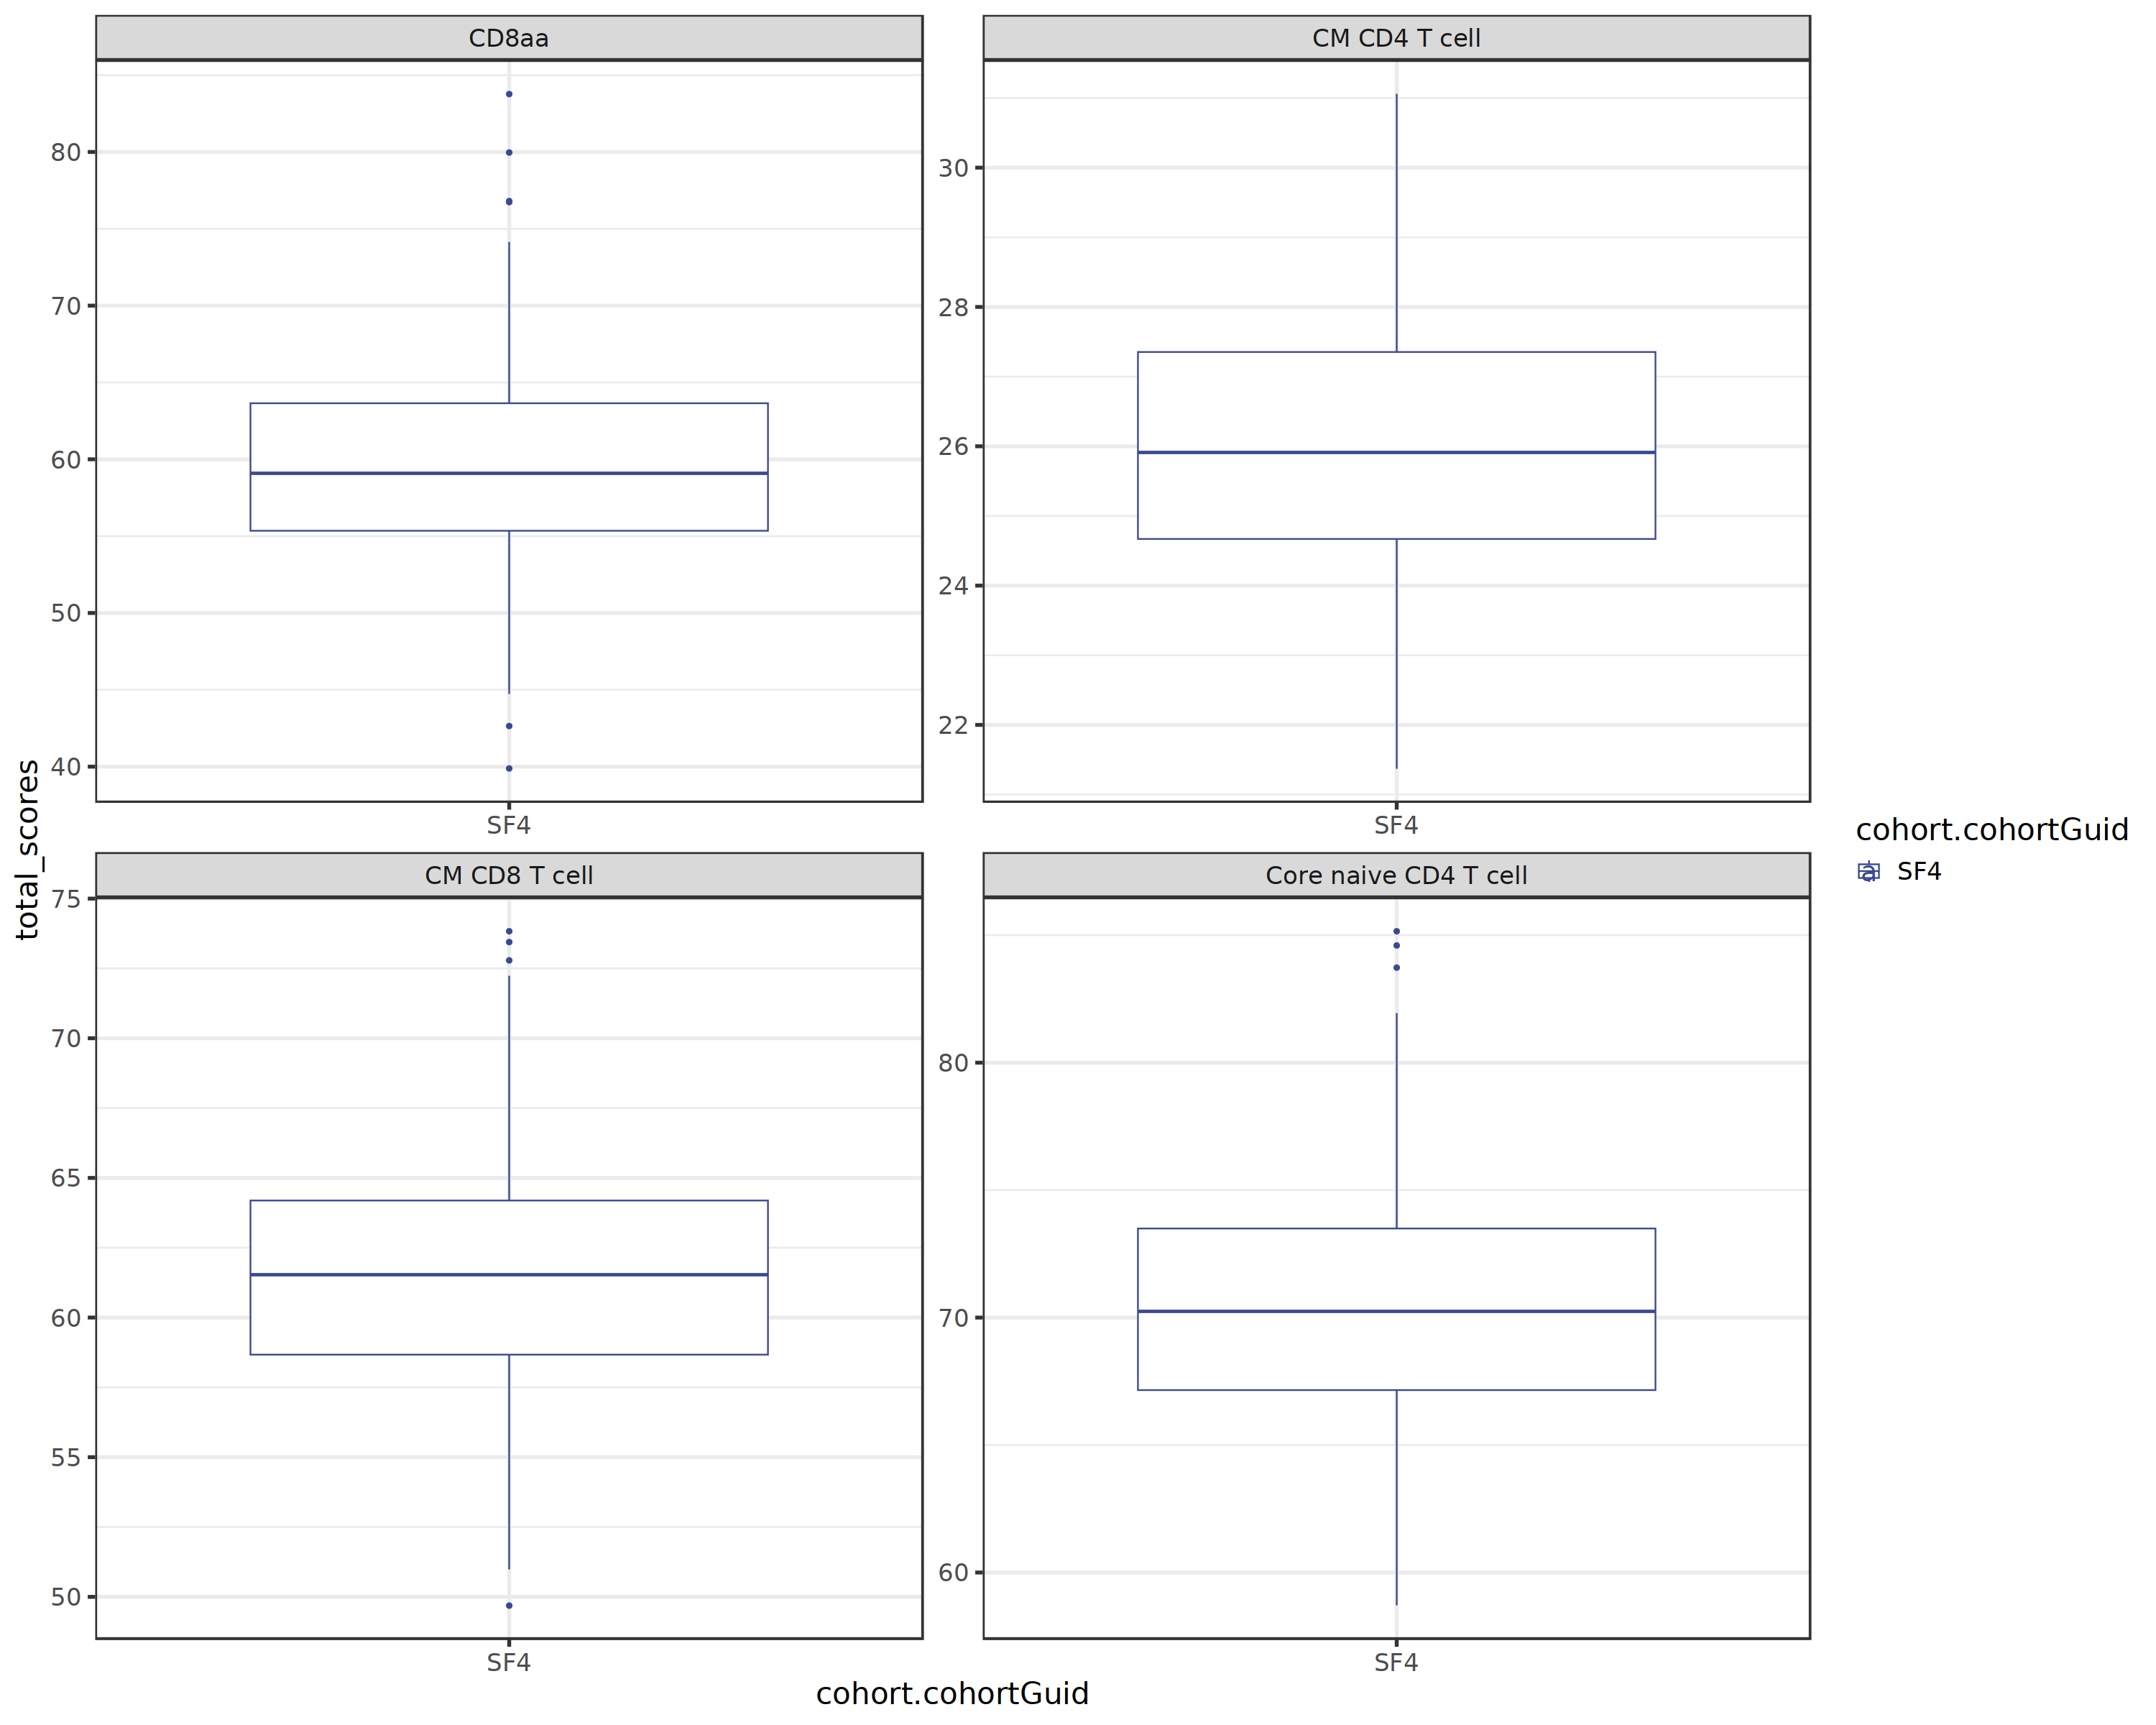

In [39]:
options(repr.plot.width = 25, repr.plot.height = 20)

ggplot(mean_df_summary_all,aes(cohort.cohortGuid, total_scores,color=cohort.cohortGuid)) +
  geom_boxplot()+scale_color_aaas()+facet_wrap(~celltype,scale="free")+stat_compare_means(size=8)+theme_bw(base_size=25)

## All data

In [32]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')

In [33]:
selected_type_list<-as.data.frame(table(DEG_sub$celltype)) %>% filter(Freq>50)

In [37]:
mean_df_summary_all<-data.frame()
for (selected_celltype in selected_type_list$Var1){
print(selected_celltype)
selected_gene=DEG_sub %>% filter(celltype == selected_celltype) %>% select(X) %>% pull()
df_list<-mclapply(meta_data$pbmc_sample_id,function(X){
df<-read.csv(paste0('/home//jupyter/BRI_Analysis/scRNA/Average_Expression_by_Celltype_and_Sample/',X,'_AIFI_L3.csv'),
             check.names = FALSE, row.names=1)
selected_celltype<-intersect(colnames(df),selected_celltype)
df_subset<-df[selected_gene,selected_celltype,drop = FALSE]
df_subset$pbmc_sample_id<-X
df_subset$Gene<-rownames(df_subset)

df_subset<-   pivot_longer(df_subset, 
                        cols = -c(pbmc_sample_id,Gene), 
                        names_to = "AIFI_L3",  
                        values_to = "Mean_Expression") 
return(df_subset)
},mc.cores=60)
mean_df<-do.call(rbind, df_list)
mean_df<-left_join(mean_df,meta_data)
mean_df<-as.data.frame(mean_df[!is.na(mean_df$X),])
mean_df$Mean_Expression<-as.numeric(mean_df$Mean_Expression)    
mean_df<-left_join(mean_df,DEG_sub,by= c("Gene" = "X","AIFI_L3" = "celltype"))
    
min_n <- DEG_sub %>%
  filter(celltype == selected_celltype) %>%
  dplyr::count(Expression) %>%
  summarise(min_count = min(n)) %>%
  pull(min_count)

top_n <- min(min_n, 100)
top_deg<-DEG_sub %>% filter(celltype ==selected_celltype) %>% 
    filter(Expression=="Up-regulated") %>% arrange(padj,desc(abs(log2FoldChange))) %>% slice_head(n=top_n)

mean_df_sub<-mean_df %>% filter(Gene %in% top_deg$X)
mean_df_sub<-mean_df_sub %>% group_by(Gene) %>% mutate(Z_score_Mean_Expression=scale(Mean_Expression))  %>% 
                                        mutate(composititon_score=Mean_Expression)  %>% 
                                        ungroup()
mean_df_summary<-mean_df_sub%>% group_by(pbmc_sample_id) %>% 
  dplyr::summarise(total_scores = sum(composititon_score))
mean_df_summary<-left_join(mean_df_summary,meta_data)
mean_df_summary$Ages<-as.numeric(substr(mean_df_summary$sample.drawDate,1,4))-mean_df_summary$subject.birthYear
mean_df_summary$celltype<-selected_celltype

mean_df_summary_all<-rbind.fill(mean_df_summary_all,mean_df_summary)
}

[1] "CD8aa"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "CM CD4 T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


[1] "CM CD8 T cell"


Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`


In [ ]:
options(repr.plot.width = 40, repr.plot.height = 25)

ggplot(mean_df_summary_all%>% filter(!sample.visitName%in% c('Flu Year 1 Day 7','Flu Year 2 Day 7'))%>% 
       filter(sample.daysSinceFirstVisit<600),
       aes(sample.daysSinceFirstVisit, 
           total_scores,
           color =cohort.cohortGuid)) +
  geom_point()+ 
  geom_smooth(method='lm')+
  scale_color_aaas()+
  facet_wrap(~celltype,scale="free",ncol=3)+
  theme_bw(base_size=25)